## Capstone Project 
### In this notebook, we will explore the neighborhood of New York City (Manhattan) and Toronto (in Canada) and try to do a comparison to sort of see how similar or different these two cities are in terms of mostly commonly used venues. We will also see how densely these venues are populated which will tell us how easily those can be accessed while roaming around the neighborhood

### Import necessary libraries to be used in the notebook

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')



Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_0         148 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

## New York City (Manhattan)  -  Segmeting and Clustering neighborhood

### 1. Downlaod and Explore Dataset

##### As we have done this previously, we can download the dataset of NY city which contains 5 boroughs with 306 neighborhood from the below link:
https://geo.nyu.edu/catalog/nyu_2451_34572
##### However, we already have this dataset in the server provided by IBM

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
print('Data loaded and ready to be explored :) see below')
#newyork_data  (I commented this line just for the sake of avoiding the length of the notebook at a later stage. If we want to see what is in data, we can uncomment it and run)

Data downloaded!
Data loaded and ready to be explored :) see below


If we look at the variable "newyork_data", it can be easily seen  that the important key is *features* which gives the neigborhoods in the city.So we will segregate this variable into a new variable as below and take a look at one of the examples

In [3]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]   ## First example of this new data

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Now we tranform this dataset into Pandas Dataframe which involves two steps:
1.  Create an empty dataframe with columns as we want
2.  Fill the appropriate column with appropriate data by looping over the entire dataset

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [5]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Now for our purpose and simplicity, let's create a new dataframe which will contain only the neighborhoods in Manhattan. Then we get the geographical co-ordinates of Manhattan and visualize the neighborhod. We will use geopy and folium as we did for the previous excercises.  

In [6]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

Borough        Neighborhood   Latitude  Longitude
0  Manhattan         Marble Hill  40.876551 -73.910660
1  Manhattan           Chinatown  40.715618 -73.994279
2  Manhattan  Washington Heights  40.851903 -73.936900
3  Manhattan              Inwood  40.867684 -73.921210
4  Manhattan    Hamilton Heights  40.823604 -73.949688

In [7]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


In [8]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
#map_manhattan

#### Define Foursquare Credentials and version

In [9]:
CLIENT_ID = 'NX2O2K34FIRA3BKVCSL4UKP5NPBKYZQLV32R0U5EICPRGEJM' # your Foursquare ID
CLIENT_SECRET = 'IACLCHPFIH5HFBJN3Z1DFTTMSRBT5CP3DFAPR5GQ2I0JRYI3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NX2O2K34FIRA3BKVCSL4UKP5NPBKYZQLV32R0U5EICPRGEJM
CLIENT_SECRET:IACLCHPFIH5HFBJN3Z1DFTTMSRBT5CP3DFAPR5GQ2I0JRYI3


#### Exploring neighborhood in Manhattan
We will explore the neighborhoods in Manhattan. We will use a foursqaure limit of 100 and create a new dataframe of Manhattan veneus which we will explore for various catagories

In [10]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [11]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [12]:
manhattan_venues_total=manhattan_venues.shape[0]
print("Size of the dataframe is " ,manhattan_venues.shape)
manhattan_venues.head(50)

Size of the dataframe is  (3317, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   Marble Hill              40.876551              -73.910660   
1   Marble Hill              40.876551              -73.910660   
2   Marble Hill              40.876551              -73.910660   
3   Marble Hill              40.876551              -73.910660   
4   Marble Hill              40.876551              -73.910660   
5   Marble Hill              40.876551              -73.910660   
6   Marble Hill              40.876551              -73.910660   
7   Marble Hill              40.876551              -73.910660   
8   Marble Hill              40.876551              -73.910660   
9   Marble Hill              40.876551              -73.910660   
10  Marble Hill              40.876551              -73.910660   
11  Marble Hill              40.876551              -73.910660   
12  Marble Hill              40.876551              -73.910660   
13  Marble Hill              40.876551              -73.910660   
14  Marble Hill              40.876551              -73.910660   
15  Marble Hill              40.876551              -73.910660   
16  Marble Hill              40.876551              -73.910660   
17  Marble Hill              40.876551              -73.910660   
18  Marble Hill              40.876551              -73.910660   
19  Marble Hill              40.876551              -73.910660   
20  Marble Hill              40.876551              -73.910660   
21  Marble Hill              40.876551              -73.910660   
22  Marble Hill              40.876551              -73.910660   
23  Marble Hill              40.876551              -73.910660   
24  Marble Hill              40.876551              -73.910660   
25    Chinatown              40.715618              -73.994279   
26    Chinatown              40.715618              -73.994279   
27    Chinatown              40.715618              -73.994279   
28    Chinatown              40.715618              -73.994279   
29    Chinatown              40.715618              -73.994279   
30    Chinatown              40.715618              -73.994279   
31    Chinatown              40.715618              -73.994279   
32    Chinatown              40.715618              -73.994279   
33    Chinatown              40.715618              -73.994279   
34    Chinatown              40.715618              -73.994279   
35    Chinatown              40.715618              -73.994279   
36    Chinatown              40.715618              -73.994279   
37    Chinatown              40.715618              -73.994279   
38    Chinatown              40.715618              -73.994279   
39    Chinatown              40.715618              -73.994279   
40    Chinatown              40.715618              -73.994279   
41    Chinatown              40.715618              -73.994279   
42    Chinatown              40.715618              -73.994279   
43    Chinatown              40.715618              -73.994279   
44    Chinatown              40.715618              -73.994279   
45    Chinatown              40.715618              -73.994279   
46    Chinatown              40.715618              -73.994279   
47    Chinatown              40.715618              -73.994279   
48    Chinatown              40.715618              -73.994279   
49    Chinatown              40.715618              -73.994279   

                                  Venue  Venue Latitude  Venue Longitude  \
0                              Arturo's       40.874412       -73.910271   
1                           Bikram Yoga       40.876844       -73.906204   
2                         Tibbett Diner       40.880404       -73.908937   
3                             Starbucks       40.877531       -73.905582   
4                               Dunkin'       40.877136       -73.906666   
5               Blink Fitness Riverdale       40.877147       -73.905837   
6             TCR The Club of Riverdale       40.878628       -73.914568   
7                 Land & Sea

##### We will check how many venues are there in each neighborhood

In [13]:
manhattan_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                
Battery Park City                      100                     100    100   
Carnegie Hill                          100                     100    100   
Central Harlem                          43                      43     43   
Chelsea                                100                     100    100   
Chinatown                              100                     100    100   
Civic Center                           100                     100    100   
Clinton                                100                     100    100   
East Harlem                             43                      43     43   
East Village                           100                     100    100   
Financial District                     100                     100    100   
Flatiron                               100                     100    100   
Gramercy                               100                     100    100   
Greenwich Village                      100                     100    100   
Hamilton Heights                        60                      60     60   
Hudson Yards                            76                      76     76   
Inwood                                  58                      58     58   
Lenox Hill                             100                     100    100   
Lincoln Square                         100                     100    100   
Little Italy                           100                     100    100   
Lower East Side                         62                      62     62   
Manhattan Valley                        59                      59     59   
Manhattanville                          41                      41     41   
Marble Hill                             25                      25     25   
Midtown                                100                     100    100   
Midtown South                          100                     100    100   
Morningside Heights                     38                      38     38   
Murray Hill                            100                     100    100   
Noho                                   100                     100    100   
Roosevelt Island                        27                      27     27   
Soho                                   100                     100    100   
Stuyvesant Town                         19                      19     19   
Sutton Place                           100                     100    100   
Tribeca                                100                     100    100   
Tudor City                              82                      82     82   
Turtle Bay                             100                     100    100   
Upper East Side                        100                     100    100   
Upper West Side                        100                     100    100   
Washington Heights                      84                      84     84   
West Village                           100                     100    100   
Yorkville                              100                     100    100   

                     Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                          
Battery Park City               100              100             100  
Carnegie Hill                   100              100             100  
Central Harlem                   43               43              43  
Chelsea                         100              100             100  
Chinatown                       100              100             100  
Civic Center                    100              100             100  
Clinton                         100              100             100  
East Harlem                      43               43              43  
East Village                    100              100             100  
Finan

#### Now let's take a look at the unique catagories among all

In [14]:
manhattan_venues_unique=len(manhattan_venues['Venue Category'].unique())
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 335 uniques categories.


#### Analyze Each Neighborhood 

In [15]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()
print("the shape is ", manhattan_onehot.shape)

the shape is  (3317, 336)


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [16]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped
print("the shape is ", manhattan_grouped.shape)

the shape is  (40, 336)


#### Let's print each neighborhood along with the top 5 most common venues

In [17]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.08
1    Coffee Shop  0.07
2          Hotel  0.05
3            Gym  0.04
4  Memorial Site  0.04


----Carnegie Hill----
            venue  freq
0     Coffee Shop  0.06
1     Pizza Place  0.06
2            Café  0.04
3     Yoga Studio  0.03
4  Cosmetics Shop  0.03


----Central Harlem----
                venue  freq
0  Chinese Restaurant  0.09
1  African Restaurant  0.07
2      Cosmetics Shop  0.05
3  Seafood Restaurant  0.05
4                 Bar  0.05


----Chelsea----
                venue  freq
0         Coffee Shop  0.06
1      Ice Cream Shop  0.05
2  Italian Restaurant  0.05
3           Nightclub  0.04
4              Bakery  0.04


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.09
1           Cocktail Bar  0.05
2    American Restaurant  0.04
3     Salon / Barbershop  0.04
4  Vietnamese Restaurant  0.04


----Civic Center----
                  venue  freq
0  Gym / Fitness Center  0.05


#### Let's put that into a *pandas* dataframe

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
print("the size is ", neighborhoods_venues_sorted.shape)

the size is  (40, 11)


#### Clustering of Manhattan Neighborhood 

Step 1 : Run *k*-means to cluster the neighborhood into 5 clusters.  
 
Step 2:  Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

Step 3:  Visualize the new cluster 

In [19]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 0, 1, 1, 2, 2, 1], dtype=int32)

In [20]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

Borough        Neighborhood   Latitude  Longitude  Cluster Labels  \
0  Manhattan         Marble Hill  40.876551 -73.910660               1   
1  Manhattan           Chinatown  40.715618 -73.994279               0   
2  Manhattan  Washington Heights  40.851903 -73.936900               2   
3  Manhattan              Inwood  40.867684 -73.921210               2   
4  Manhattan    Hamilton Heights  40.823604 -73.949688               2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0        Sandwich Place        Discount Store           Coffee Shop   
1    Chinese Restaurant          Cocktail Bar    Salon / Barbershop   
2                  Café                Bakery    Spanish Restaurant   
3                Lounge    Mexican Restaurant                  Café   
4                  Café           Pizza Place    Mexican Restaurant   

  4th Most Common Venue  5th Most Common Venue 6th Most Common Venue  \
0        Clothing Store         Tennis Stadium         Big Box Store   
1   American Restaurant  Vietnamese Restaurant                   Spa   
2         Grocery Store      Mobile Phone Shop    Mexican Restaurant   
3           Pizza Place             Restaurant                Bakery   
4           Coffee Shop            Yoga Studio                School   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0       Supplement Shop            Steakhouse         Shopping Mall   
1       Bubble Tea Shop   Dumpling Restaurant        Ice Cream Shop   
2      Tapas Restaurant                  Park         Deli / Bodega   
3    Spanish Restaurant  Caribbean Restaurant    Chinese Restaurant   
4                Bakery          Liquor Store        Sandwich Place   

  10th Most Common Venue  
0     Seafood Restaurant  
1                 Bakery  
2     Chinese Restaurant  
3                   Park  
4       Sushi Restaurant

In [21]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine All 5 Clusters

#### Cluster1 of Manhattan

In [24]:
m_c1 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
m_c1

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
2   Washington Heights                  Café     Mobile Phone Shop   
3               Inwood    Mexican Restaurant                  Café   
4     Hamilton Heights           Coffee Shop    Mexican Restaurant   
7          East Harlem    Mexican Restaurant         Deli / Bodega   
20     Lower East Side           Pizza Place           Coffee Shop   
25    Manhattan Valley     Indian Restaurant           Pizza Place   
36          Tudor City    Mexican Restaurant                  Park   

   3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
2                 Bakery              Grocery Store           Coffee Shop   
3                 Lounge                Pizza Place                  Park   
4            Pizza Place                       Café           Yoga Studio   
7                 Bakery  Latin American Restaurant       Thai Restaurant   
20      Ramen Restaurant                Art Gallery    Chinese Restaurant   
25           Coffee Shop                Yoga Studio                   Bar   
36      Greek Restaurant                       Café         Deli / Bodega   

   6th Most Common Venue 7th Most Common Venue      8th Most Common Venue  \
2     Mexican Restaurant          Liquor Store  Latin American Restaurant   
3                 Bakery  Caribbean Restaurant         Chinese Restaurant   
4      Indian Restaurant      Sushi Restaurant             Sandwich Place   
7            Gas Station            Donut Shop               Liquor Store   
20                  Café          Cocktail Bar        Japanese Restaurant   
25       Thai Restaurant                  Café         Mexican Restaurant   
36                 Hotel      Sushi Restaurant                Pizza Place   

      9th Most Common Venue 10th Most Common Venue  
2   New American Restaurant                   Park  
3                Restaurant     Frozen Yogurt Shop  
4             Deli / Bodega           Liquor Store  
7               Coffee Shop           Cocktail Bar  
20               Shoe Store                 Bakery  
25            Deli / Bodega    Hawaiian Restaurant  
36                  Dog Run                    Spa

#### Cluster2 of Manhattan

In [25]:
m_c2 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
m_c2

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0          Marble Hill        Sandwich Place        Discount Store   
1            Chinatown    Chinese Restaurant          Cocktail Bar   
5       Manhattanville    Italian Restaurant    Mexican Restaurant   
6       Central Harlem    African Restaurant  Gym / Fitness Center   
9            Yorkville    Italian Restaurant                   Gym   
11    Roosevelt Island        Sandwich Place           Coffee Shop   
12     Upper West Side    Italian Restaurant              Wine Bar   
16         Murray Hill        Sandwich Place           Coffee Shop   
19        East Village                   Bar              Wine Bar   
22        Little Italy                Bakery                  Café   
27            Gramercy    Italian Restaurant          Cocktail Bar   
29  Financial District           Coffee Shop                   Gym   
30       Carnegie Hill           Coffee Shop           Pizza Place   
33       Midtown South     Korean Restaurant                 Hotel   
34        Sutton Place  Gym / Fitness Center    Italian Restaurant   
35          Turtle Bay    Italian Restaurant            Steakhouse   
38            Flatiron                   Gym           Yoga Studio   

   3rd Most Common Venue   4th Most Common Venue  \
0            Coffee Shop             Yoga Studio   
1    American Restaurant   Vietnamese Restaurant   
5     Seafood Restaurant             Coffee Shop   
6                    Bar          Cosmetics Shop   
9                    Bar             Coffee Shop   
11       Bubble Tea Shop   Outdoors & Recreation   
12                   Bar       Indian Restaurant   
16   Japanese Restaurant                   Hotel   
19    Chinese Restaurant          Ice Cream Shop   
22       Bubble Tea Shop          Clothing Store   
27   American Restaurant             Pizza Place   
29            Steakhouse               Wine Shop   
30                  Café             Yoga Studio   
33          Dessert Shop     Japanese Restaurant   
34     Indian Restaurant  Furniture / Home Store   
35           Coffee Shop        Sushi Restaurant   
38   American Restaurant     Japanese Restaurant   

            5th Most Common Venue     6th Most Common Venue  \
0                  Clothing Store           Supplement Shop   
1              Salon / Barbershop                    Bakery   
5                            Park             Deli / Bodega   
6             American Restaurant         French Restaurant   
9                     Pizza Place          Sushi Restaurant   
11                   Liquor Store          Greek Restaurant   
12  Vegetarian / Vegan Restaurant  Mediterranean Restaurant   
16             Italian Restaurant                       Gym   
19                    Pizza Place              Cocktail Bar   
22                 Sandwich Place            Cosmetics Shop   
27                     Bagel Shop                       Bar   
29                          Hotel        Italian Restaurant   
30                            Spa                    Bakery   
33                      Hotel Bar            Cosmetics Shop   
34                   Dessert Shop                       Gym   
35                       Wine Bar          Ramen Restaurant   
38           Gym / Fitness Center            Clothing Store   

   7th Most Common Venue     8th Most Common Venue    9th Most Common Venue  \
0                    Gym                Donut Shop            Shopping Mall   
1        Bubble Tea Shop                       Spa      Dumpling Restaurant   
5            Supermarket              Burger Joint       Spanish Restaurant   
6     Seafood Restaurant        Chinese Restaurant     Ethiopian Restaurant   
9              Wine Shop       Japanese Restaurant       Mexican Restaurant   
11         Metro Station               Supermarket                 Bus Line   
12           Coffee Shop                    Bakery           Breakfast Spot   
16  Gym / Fitness Center        Salon / Barbe

#### Cluster3 of Manhattan

In [26]:
m_c3 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
m_c3

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
8     Upper East Side    Italian Restaurant               Exhibit   
10         Lenox Hill    Italian Restaurant           Coffee Shop   
13     Lincoln Square               Theater  Gym / Fitness Center   
14            Clinton               Theater  Gym / Fitness Center   
15            Midtown                 Hotel        Clothing Store   
17            Chelsea           Coffee Shop    Italian Restaurant   
18  Greenwich Village    Italian Restaurant        Clothing Store   
21            Tribeca    Italian Restaurant                   Spa   
23               Soho        Clothing Store              Boutique   
24       West Village    Italian Restaurant        Cosmetics Shop   
28  Battery Park City                  Park           Coffee Shop   
31               Noho    Italian Restaurant     French Restaurant   
32       Civic Center  Gym / Fitness Center    Italian Restaurant   
39       Hudson Yards   American Restaurant    Italian Restaurant   

      3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
8               Art Gallery                Bakery  Gym / Fitness Center   
10              Pizza Place      Sushi Restaurant  Gym / Fitness Center   
13                     Café                 Plaza          Concert Hall   
14      American Restaurant                 Hotel    Italian Restaurant   
15                  Theater           Coffee Shop          Cocktail Bar   
17           Ice Cream Shop                Bakery             Nightclub   
18         Sushi Restaurant                  Café    Seafood Restaurant   
21                     Park                  Café   American Restaurant   
23               Shoe Store           Art Gallery         Women's Store   
24  New American Restaurant          Cocktail Bar   American Restaurant   
28                    Hotel                   Gym         Memorial Site   
31             Cocktail Bar           Coffee Shop             Rock Club   
32              Coffee Shop     French Restaurant                 Hotel   
39                     Café  Gym / Fitness Center                 Hotel   

     6th Most Common Venue 7th Most Common Venue     8th Most Common Venue  \
8             Cocktail Bar           Coffee Shop         French Restaurant   
10     Sporting Goods Shop          Burger Joint            Cosmetics Shop   
13      Italian Restaurant     French Restaurant     Performing Arts Venue   
14               Wine Shop           Coffee Shop            Sandwich Place   
15     Japanese Restaurant   American Restaurant                       Spa   
17                   Hotel   American Restaurant                   Theater   
18       Indian Restaurant        Cosmetics Shop        Chinese Restaurant   
21                Boutique             Wine Shop                  Wine Bar   
23  Furniture / Home Store           Men's Store  Mediterranean Restaurant   
24                Wine Bar             Jazz Club                      Park   
28      Italian Restaurant             Wine Shop              Burger Joint   
31             Pizza Place    Mexican Restaurant                 Gift Shop   
32          Sandwich Place   Sporting Goods Shop       American Restaurant   
39              Restaurant               Dog Run               Coffee Shop   

   9th Most Common Venue 10th Most Common Venue  
8                  Hotel              Juice Bar  
10                   Gym          Deli / Bodega  
13                  Park            Opera House  
14                   Spa             Food Court  
15                Bakery              Bookstore  
17    Seafood Restaurant            Art Gallery  
18     French Restaurant           Burger Joint  
21                   Gym       Greek Restaurant  
23                 Hotel     Italian Restaurant  
24           Coffee Shop                 Bakery  
28        Ice Cream Shop           Cupcake Shop  
31      Sushi Restaurant               Boutique  
32                Bakery  

#### Cluster4 of Manhattan

In [27]:
m_c4 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
m_c4

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
37  Stuyvesant Town                   Bar                  Park   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
37            Playground         Boat or Ferry      Basketball Court   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
37        Baseball Field              Fountain          Cocktail Bar   

   9th Most Common Venue 10th Most Common Venue  
37       Harbor / Marina            Coffee Shop

#### Cluster5 of Manhattan

In [28]:
m_c5 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
m_c5

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
26  Morningside Heights             Bookstore   American Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
26           Coffee Shop                  Park          Tennis Court   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
26          Burger Joint         Deli / Bodega            Food Truck   

   9th Most Common Venue 10th Most Common Venue  
26        Ice Cream Shop      College Cafeteria

###  Toronto - Segmenting and Clustering Neighborhood

#### Fetching the data and arranging it for analysis.
Use BeautifulSoup to scrape the data from Wikipedia

Convert the data to the padas dataframe

In [22]:
import numpy as np
import pandas as pd
import requests
web_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
print("Website successfully read and html received ")
import bs4 as bs
soup = bs.BeautifulSoup(web_url, 'lxml')
#print(soup.prettify)
My_table = soup.find('table',{'class':'wikitable sortable'})
cols = 3
h = [head.findAll(text=True)[0].strip() for head in My_table.find_all("th")]
  
my_data = [[td.findAll(text=True)[0].strip() for td in tr.find_all("td")]
              for tr in My_table.find_all("tr")]

my_data   = [row for row in my_data if len(row) == cols]
df = pd.DataFrame(my_data,columns=h)
df

Website successfully read and html received 


Postcode           Borough  \
0        M1A      Not assigned   
1        M2A      Not assigned   
2        M3A        North York   
3        M4A        North York   
4        M5A  Downtown Toronto   
5        M5A  Downtown Toronto   
6        M6A        North York   
7        M6A        North York   
8        M7A      Queen's Park   
9        M8A      Not assigned   
10       M9A         Etobicoke   
11       M1B       Scarborough   
12       M1B       Scarborough   
13       M2B      Not assigned   
14       M3B        North York   
15       M4B         East York   
16       M4B         East York   
17       M5B  Downtown Toronto   
18       M5B  Downtown Toronto   
19       M6B        North York   
20       M7B      Not assigned   
21       M8B      Not assigned   
22       M9B         Etobicoke   
23       M9B         Etobicoke   
24       M9B         Etobicoke   
25       M9B         Etobicoke   
26       M9B         Etobicoke   
27       M1C       Scarborough   
28       M1C       Scarborough   
29       M1C       Scarborough   
30       M2C      Not assigned   
31       M3C        North York   
32       M3C        North York   
33       M4C         East York   
34       M5C  Downtown Toronto   
35       M6C              York   
36       M7C      Not assigned   
37       M8C      Not assigned   
38       M9C         Etobicoke   
39       M9C         Etobicoke   
40       M9C         Etobicoke   
41       M9C         Etobicoke   
42       M1E       Scarborough   
43       M1E       Scarborough   
44       M1E       Scarborough   
45       M2E      Not assigned   
46       M3E      Not assigned   
47       M4E      East Toronto   
48       M5E  Downtown Toronto   
49       M6E              York   
50       M7E      Not assigned   
51       M8E      Not assigned   
52       M9E      Not assigned   
53       M1G       Scarborough   
54       M2G      Not assigned   
55       M3G      Not assigned   
56       M4G         East York   
57       M5G  Downtown Toronto   
58       M6G  Downtown Toronto   
59       M7G      Not assigned   
60       M8G      Not assigned   
61       M9G      Not assigned   
62       M1H       Scarborough   
63       M2H        North York   
64       M3H        North York   
65       M3H        North York   
66       M3H        North York   
67       M4H         East York   
68       M5H  Downtown Toronto   
69       M5H  Downtown Toronto   
70       M5H  Downtown Toronto   
71       M6H      West Toronto   
72       M6H      West Toronto   
73       M7H      Not assigned   
74       M8H      Not assigned   
75       M9H      Not assigned   
76       M1J       Scarborough   
77       M2J        North York   
78       M2J        North York   
79       M2J        North York   
80       M3J        North York   
81       M3J        North York   
82       M4J         East York   
83       M5J  Downtown Toronto   
84       M5J  Downtown Toronto   
85       M5J  Downtown Toronto   
86       M6J      West Toronto   
87       M6J      West Toronto   
88       M7J      Not assigned   
89       M8J      Not assigned   
90       M9J      Not assigned   
91       M1K       Scarborough   
92       M1K       Scarborough   
93       M1K       Scarborough   
94       M2K        North York   
95       M3K        North York   
96       M3K        North York   
97       M4K      East Toronto   
98       M4K      East Toronto   
99       M5K  Downtown Toronto   
100      M5K  Downtown Toronto   
101      M6K      West Toronto   
102      M6K      West Toronto   
103      M6K      West Toronto   
104      M7K      Not assigned   
105      M8K      Not assigned   
106      M9K      Not assigned   
107      M1L       Scarborough   
108      M1L       Scarborough   
109      M1L       Scarborough   
110      M2L        North York   
111      M2L        North York   
112      M3L        North York   
113      M4L      East Toronto   
114      M4L      East Toronto   
115      M5L  Downtown Toronto   
116      M5L  Downtown Tor

In [23]:
df.to_csv('Canada_data_1.csv', index=False)
Canada_data = 'Canada_data_1.csv'
df_r_new = pd.read_csv(Canada_data)
df_r_new.shape

(288, 3)

#### Cleaning up the data:
Delete cells with boroughs = Not Assigned.

If a cell has a Borough with neighborhood is "Not Assigned", then the neighborhood will be the same as the borough.

Group the table by PostalCod and Borough, Neighbourhood belonging to same Borough will be combined in 'Neighbourhood' column separated by a ','.
reset the index of the whole dataset

In [24]:
df_r = df_r_new[df['Borough'] !='Not assigned']
df_r.shape
#df=df.sort_values(by=['Postcode','Borough','Neighbourhood'], ascending=[1,1,1]).reset_index(drop=True)
df_r.loc[df['Neighbourhood'] == 'Not assigned', 'Neighbourhood'] = df['Borough']
df_r.shape
df_r = df_r.groupby(['Postcode', 'Borough'], sort = False).agg(', '.join).reset_index()
#df_r
#df_r.reset_index()
#df = df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index
#df

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
df_r.to_csv('Canada_f1.csv',index=False)

#### Read the geospatial data for latitute and longitute and merge the information into the existing table
Read the data from the .csv file

Read the neighborhood data from the already created .csv

Replace the name of the first column (eg. Postcode --> Postalcode) to match the geospatial data column name

Merge both the tables and display

In [26]:
!wget -q -O 'Canada_lat_long.csv'  http://cocl.us/Geospatial_data
df_lat_long = pd.read_csv('Canada_lat_long.csv')
#df_lat_long.head()
df_lat_long.columns=['Postalcode','Latitude','Longitude']
#df_r.columns = ['Postalcode', 'Borough', 'Neighbourhood']
#df_lat_long.head()
Canada_data = 'Canada_f1.csv'
df_r_new = pd.read_csv(Canada_data)
df_r_new.head()
df_r_new = df_r_new.rename(index=str,columns={"Postcode": "Postalcode", "Borough": "Borough", "Neighbourhood": "Neighbourhood"})
df_r_new.head()
#df_r_new = pd.read_csv(Canada_data).set_index("Postcode")
#df_r_new.rename_axis("Postal Code", axis='index', inplace=True)
#df_r_new.head()
Canada_data = pd.merge(df_r_new, df_lat_long[['Postalcode', 'Latitude', 'Longitude']], on = 'Postalcode')
Canada_data

Postalcode           Borough  \
0          M3A        North York   
1          M4A        North York   
2          M5A  Downtown Toronto   
3          M6A        North York   
4          M7A      Queen's Park   
5          M9A         Etobicoke   
6          M1B       Scarborough   
7          M3B        North York   
8          M4B         East York   
9          M5B  Downtown Toronto   
10         M6B        North York   
11         M9B         Etobicoke   
12         M1C       Scarborough   
13         M3C        North York   
14         M4C         East York   
15         M5C  Downtown Toronto   
16         M6C              York   
17         M9C         Etobicoke   
18         M1E       Scarborough   
19         M4E      East Toronto   
20         M5E  Downtown Toronto   
21         M6E              York   
22         M1G       Scarborough   
23         M4G         East York   
24         M5G  Downtown Toronto   
25         M6G  Downtown Toronto   
26         M1H       Scarborough   
27         M2H        North York   
28         M3H        North York   
29         M4H         East York   
30         M5H  Downtown Toronto   
31         M6H      West Toronto   
32         M1J       Scarborough   
33         M2J        North York   
34         M3J        North York   
35         M4J         East York   
36         M5J  Downtown Toronto   
37         M6J      West Toronto   
38         M1K       Scarborough   
39         M2K        North York   
40         M3K        North York   
41         M4K      East Toronto   
42         M5K  Downtown Toronto   
43         M6K      West Toronto   
44         M1L       Scarborough   
45         M2L        North York   
46         M3L        North York   
47         M4L      East Toronto   
48         M5L  Downtown Toronto   
49         M6L        North York   
50         M9L        North York   
51         M1M       Scarborough   
52         M2M        North York   
53         M3M        North York   
54         M4M      East Toronto   
55         M5M        North York   
56         M6M              York   
57         M9M        North York   
58         M1N       Scarborough   
59         M2N        North York   
60         M3N        North York   
61         M4N   Central Toronto   
62         M5N   Central Toronto   
63         M6N              York   
64         M9N              York   
65         M1P       Scarborough   
66         M2P        North York   
67         M4P   Central Toronto   
68         M5P   Central Toronto   
69         M6P      West Toronto   
70         M9P         Etobicoke   
71         M1R       Scarborough   
72         M2R        North York   
73         M4R   Central Toronto   
74         M5R   Central Toronto   
75         M6R      West Toronto   
76         M7R       Mississauga   
77         M9R         Etobicoke   
78         M1S       Scarborough   
79         M4S   Central Toronto   
80         M5S  Downtown Toronto   
81         M6S      West Toronto   
82         M1T       Scarborough   
83         M4T   Central Toronto   
84         M5T  Downtown Toronto   
85         M1V       Scarborough   
86         M4V   Central Toronto   
87         M5V  Downtown Toronto   
88         M8V         Etobicoke   
89         M9V         Etobicoke   
90         M1W       Scarborough   
91         M4W  Downtown Toronto   
92         M5W  Downtown Toronto   
93         M8W         Etobicoke   
94         M9W         Etobicoke   
95         M1X       Scarborough   
96         M4X  Downtown Toronto   
97         M5X  Downtown Toronto   
98         M8X         Etobicoke   
99         M4Y  Downtown Toronto   
100        M7Y      East Toronto   
101        M8Y         Etobicoke   
102        M8Z         Etobicoke   

                                         Neighbourhood   Latitude  Longitude  
0                                            Parkwoods  43.753259 -79.329656  
1                                     Victoria Village  43.725882 -79.315572  
2                     

#### Explore neighborhood in Toronto
Here we will explore the neighborhoof in Toronto pretty much the same way we have done in the previous ungraded excerside where exploration was done for the neighborhood ofNew York City

Fetch the data from the previoues excercise from the existing .csv file and read it to the pandas dataframe

In [27]:
Canada_data = 'Canada_f1.csv'
df_r_new = pd.read_csv(Canada_data)
df_r_new = df_r_new.rename(index=str,columns={"Postcode": "Postalcode", "Borough": "Borough", "Neighbourhood": "Neighbourhood"})
#df_r_new = pd.read_csv(Canada_data).set_index("Postcode")
#df_r_new.rename_axis("Postal Code", axis='index', inplace=True)
#df_r_new.head()
Canada_data = pd.merge(df_r_new, df_lat_long[['Postalcode', 'Latitude', 'Longitude']], on = 'Postalcode')
Canada_data

Postalcode           Borough  \
0          M3A        North York   
1          M4A        North York   
2          M5A  Downtown Toronto   
3          M6A        North York   
4          M7A      Queen's Park   
5          M9A         Etobicoke   
6          M1B       Scarborough   
7          M3B        North York   
8          M4B         East York   
9          M5B  Downtown Toronto   
10         M6B        North York   
11         M9B         Etobicoke   
12         M1C       Scarborough   
13         M3C        North York   
14         M4C         East York   
15         M5C  Downtown Toronto   
16         M6C              York   
17         M9C         Etobicoke   
18         M1E       Scarborough   
19         M4E      East Toronto   
20         M5E  Downtown Toronto   
21         M6E              York   
22         M1G       Scarborough   
23         M4G         East York   
24         M5G  Downtown Toronto   
25         M6G  Downtown Toronto   
26         M1H       Scarborough   
27         M2H        North York   
28         M3H        North York   
29         M4H         East York   
30         M5H  Downtown Toronto   
31         M6H      West Toronto   
32         M1J       Scarborough   
33         M2J        North York   
34         M3J        North York   
35         M4J         East York   
36         M5J  Downtown Toronto   
37         M6J      West Toronto   
38         M1K       Scarborough   
39         M2K        North York   
40         M3K        North York   
41         M4K      East Toronto   
42         M5K  Downtown Toronto   
43         M6K      West Toronto   
44         M1L       Scarborough   
45         M2L        North York   
46         M3L        North York   
47         M4L      East Toronto   
48         M5L  Downtown Toronto   
49         M6L        North York   
50         M9L        North York   
51         M1M       Scarborough   
52         M2M        North York   
53         M3M        North York   
54         M4M      East Toronto   
55         M5M        North York   
56         M6M              York   
57         M9M        North York   
58         M1N       Scarborough   
59         M2N        North York   
60         M3N        North York   
61         M4N   Central Toronto   
62         M5N   Central Toronto   
63         M6N              York   
64         M9N              York   
65         M1P       Scarborough   
66         M2P        North York   
67         M4P   Central Toronto   
68         M5P   Central Toronto   
69         M6P      West Toronto   
70         M9P         Etobicoke   
71         M1R       Scarborough   
72         M2R        North York   
73         M4R   Central Toronto   
74         M5R   Central Toronto   
75         M6R      West Toronto   
76         M7R       Mississauga   
77         M9R         Etobicoke   
78         M1S       Scarborough   
79         M4S   Central Toronto   
80         M5S  Downtown Toronto   
81         M6S      West Toronto   
82         M1T       Scarborough   
83         M4T   Central Toronto   
84         M5T  Downtown Toronto   
85         M1V       Scarborough   
86         M4V   Central Toronto   
87         M5V  Downtown Toronto   
88         M8V         Etobicoke   
89         M9V         Etobicoke   
90         M1W       Scarborough   
91         M4W  Downtown Toronto   
92         M5W  Downtown Toronto   
93         M8W         Etobicoke   
94         M9W         Etobicoke   
95         M1X       Scarborough   
96         M4X  Downtown Toronto   
97         M5X  Downtown Toronto   
98         M8X         Etobicoke   
99         M4Y  Downtown Toronto   
100        M7Y      East Toronto   
101        M8Y         Etobicoke   
102        M8Z         Etobicoke   

                                         Neighbourhood   Latitude  Longitude  
0                                            Parkwoods  43.753259 -79.329656  
1                                     Victoria Village  43.725882 -79.315572  
2                     

In [28]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(Canada_data['Borough'].unique()),
        Canada_data.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


#### Using geopy libraries to get the lattitue and longitude of Toronto, ON

In [29]:
from geopy.geocoders import Nominatim
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


#### Map creation of Toronto with neighborhood superimposed

In [30]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(Canada_data['Latitude'], Canada_data['Longitude'], Canada_data['Borough'], Canada_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
##map_toronto

### Exploring neighborhoods in Toronto

In [31]:
radius = 500
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
toronto_venues = getNearbyVenues(names=Canada_data['Neighbourhood'],
                                   latitudes=Canada_data['Latitude'],
                                   longitudes=Canada_data['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Heights, Lawrence Manor
Queen's Park
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The D

In [33]:
print(toronto_venues.shape)
toronto_venues_total=toronto_venues.shape[0]
toronto_venues.head()

(2279, 7)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0         Parkwoods               43.753259               -79.329656   
1         Parkwoods               43.753259               -79.329656   
2         Parkwoods               43.753259               -79.329656   
3         Parkwoods               43.753259               -79.329656   
4  Victoria Village               43.725882               -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1                     KFC       43.754387       -79.333021   
2          TTC stop #8380       43.752672       -79.326351   
3           Variety Store       43.751974       -79.333114   
4  Victoria Village Arena       43.723481       -79.315635   

         Venue Category  
0                  Park  
1  Fast Food Restaurant  
2              Bus Stop  
3     Food & Drink Shop  
4          Hockey Arena

#### Number of venues returned for each neighborhood:

In [34]:
toronto_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  \
Neighbourhood                                                                
Adelaide, King, Richmond                                               100   
Agincourt                                                                4   
Agincourt North, L'Amoreaux East, Milliken, Ste...                       2   
Albion Gardens, Beaumond Heights, Humbergate, J...                       9   
Alderwood, Long Branch                                                  10   
Bathurst Manor, Downsview North, Wilson Heights                         20   
Bayview Village                                                          4   
Bedford Park, Lawrence Manor East                                       25   
Berczy Park                                                             57   
Birch Cliff, Cliffside West                                              4   
Bloordale Gardens, Eringate, Markland Wood, Old...                       8   
Brockton, Exhibition Place, Parkdale Village                            27   
Business Reply Mail Processing Centre 969 Eastern                       19   
CFB Toronto, Downsview East                                              2   
CN Tower, Bathurst Quay, Island airport, Harbou...                      16   
Cabbagetown, St. James Town                                             45   
Caledonia-Fairbanks                                                      6   
Canada Post Gateway Processing Centre                                   11   
Cedarbrae                                                                7   
Central Bay Street                                                      89   
Chinatown, Grange Park, Kensington Market                              100   
Christie                                                                16   
Church and Wellesley                                                    88   
Clairlea, Golden Mile, Oakridge                                          8   
Clarks Corners, Sullivan, Tam O'Shanter                                 11   
Cliffcrest, Cliffside, Scarborough Village West                          2   
Cloverdale, Islington, Martin Grove, Princess G...                       1   
Commerce Court, Victoria Hotel                                         100   
Davisville                                                              32   
Davisville North                                                        10   
Deer Park, Forest Hill SE, Rathnelly, South Hil...                      15   
Del Ray, Keelesdale, Mount Dennis, Silverthorn                           4   
Design Exchange, Toronto Dominion Centre                               100   
Don Mills North                                                          5   
Dorset Park, Scarborough Town Centre, Wexford H...                       6   
Dovercourt Village, Dufferin                                            21   
Downsview Central                                                        2   
Downsview Northwest                                                      5   
Downsview West                                                           6   
Downsview, North Park, Upwood Park                                       4   
East Birchmount Park, Ionview, Kennedy Park                              4   
East Toronto                                                             3   
Emery, Humberlea                                                         3   
Fairview, Henry Farm, Oriole                                            69   
First Canadian Place, Underground city                                 100   
Flemingdon Park, Don Mills South                                        21   
Forest Hill North, Forest Hill West                                      5   
Glencairn                                                                4   
Guildwood, Morningside, West Hill                                        8   
Harbord, University of Toronto                                          35

#### Unique catagories :

In [35]:
toronto_venues_unique=len(toronto_venues['Venue Category'].unique())
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 276 uniques categories.


#### Analyzing each neighborhood

In [36]:

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
print ("One hot shape :" ,toronto_onehot.shape)
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
print ("toronto_grouped.shape :",toronto_grouped.shape)

One hot shape : (2279, 277)
toronto_grouped.shape : (99, 277)


In [37]:
toronto_onehot.head()

Accessories Store  Afghan Restaurant  Airport  Airport Food Court  \
0                  0                  0        0                   0   
1                  0                  0        0                   0   
2                  0                  0        0                   0   
3                  0                  0        0                   0   
4                  0                  0        0                   0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0             0               0                0                 0   
1             0               0                0                 0   
2             0               0                0                 0   
3             0               0                0                 0   
4             0               0                0                 0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0                    0             0         0            0           0   
1                    0             0         0            0           0   
2                    0             0         0            0           0   
3                    0             0         0            0           0   
4                    0             0         0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0                    0                 0                   0              0   
1                    0                 0                   0              0   
2                    0                 0                   0              0   
3                    0                 0                   0              0   
4                    0                 0                   0              0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    0               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  Beer Bar  \
0                 0                 0                   0      0         0   
1                 0                 0                   0      0         0   
2                 0                 0                   0      0         0   
3                 0                 0                   0      0         0   
4                 0                 0                   0      0         0   

   Beer Store  Belgian Restaurant  Bike Shop  Bistro  Board Shop  \
0           0                   0          0       0           0   
1           0                   0          0       0           0   
2           0                   0          0       0           0   
3           0                   0          0       0           0   
4           0                   0          0       0           0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0              0          0         0                     0               0   
1              0          0         0                     0               0   
2              0          0         0                     0               0   
3              0          0         0                     0               0   
4              0          0         0                     0               0   

   Brewery  Bridal Shop  Bubble Tea Shop  Building  Burger Joint  \
0        0            0                0         0             0   
1        0            0                0         0             0   
2        0            0                0         0             0   
3        0            0                0         0             0   
4        0            0                0         0             0   

   Burrito

##### Group rows by neighborhood using the mean of the frequency of occurrence of each category

In [38]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
print("Teh shape of the grouped data =", toronto_grouped.shape)
toronto_grouped

Teh shape of the grouped data = (99, 277)


Neighbourhood  Accessories Store  \
0                            Adelaide, King, Richmond           0.000000   
1                                           Agincourt           0.000000   
2   Agincourt North, L'Amoreaux East, Milliken, St...           0.000000   
3   Albion Gardens, Beaumond Heights, Humbergate, ...           0.000000   
4                              Alderwood, Long Branch           0.000000   
5     Bathurst Manor, Downsview North, Wilson Heights           0.000000   
6                                     Bayview Village           0.000000   
7                   Bedford Park, Lawrence Manor East           0.000000   
8                                         Berczy Park           0.000000   
9                         Birch Cliff, Cliffside West           0.000000   
10  Bloordale Gardens, Eringate, Markland Wood, Ol...           0.000000   
11       Brockton, Exhibition Place, Parkdale Village           0.000000   
12  Business Reply Mail Processing Centre 969 Eastern           0.000000   
13                        CFB Toronto, Downsview East           0.000000   
14  CN Tower, Bathurst Quay, Island airport, Harbo...           0.000000   
15                        Cabbagetown, St. James Town           0.000000   
16                                Caledonia-Fairbanks           0.000000   
17              Canada Post Gateway Processing Centre           0.000000   
18                                          Cedarbrae           0.000000   
19                                 Central Bay Street           0.000000   
20          Chinatown, Grange Park, Kensington Market           0.000000   
21                                           Christie           0.000000   
22                               Church and Wellesley           0.000000   
23                    Clairlea, Golden Mile, Oakridge           0.000000   
24            Clarks Corners, Sullivan, Tam O'Shanter           0.000000   
25    Cliffcrest, Cliffside, Scarborough Village West           0.000000   
26  Cloverdale, Islington, Martin Grove, Princess ...           0.000000   
27                     Commerce Court, Victoria Hotel           0.000000   
28                                         Davisville           0.000000   
29                                   Davisville North           0.000000   
30  Deer Park, Forest Hill SE, Rathnelly, South Hi...           0.000000   
31     Del Ray, Keelesdale, Mount Dennis, Silverthorn           0.000000   
32           Design Exchange, Toronto Dominion Centre           0.000000   
33                                    Don Mills North           0.000000   
34  Dorset Park, Scarborough Town Centre, Wexford ...           0.000000   
35                       Dovercourt Village, Dufferin           0.000000   
36                                  Downsview Central           0.000000   
37                                Downsview Northwest           0.000000   
38                                     Downsview West           0.000000   
39                 Downsview, North Park, Upwood Park           0.000000   
40        East Birchmount Park, Ionview, Kennedy Park           0.000000   
41                                       East Toronto           0.000000   
42                                   Emery, Humberlea           0.000000   
43                       Fairview, Henry Farm, Oriole           0.000000   
44             First Canadian Place, Underground city           0.000000   
45                   Flemingdon Park, Don Mills South           0.000000   
46                Forest Hill North, Forest Hill West           0.000000   
47                                          Glencairn           0.000000   
48                  Guildwood, Morningside, West Hill           0.000000   
49                     Harbord, University of Toronto           0.000000   
50  Harbourfront East, Toronto Islands, Union Station           0.000000   
51                          Harbourfront, Regent Park           0.000000   
52          

#### Top 5 common venues of each neighborhood

In [39]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.05
2  American Restaurant  0.04
3      Thai Restaurant  0.04
4           Steakhouse  0.04


----Agincourt----
               venue  freq
0       Skating Rink  0.25
1     Breakfast Spot  0.25
2     Clothing Store  0.25
3             Lounge  0.25
4  Accessories Store  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
               venue  freq
0         Playground   0.5
1               Park   0.5
2  Mobile Phone Shop   0.0
3             Museum   0.0
4      Movie Theater   0.0


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0         Grocery Store  0.22
1  Fast Food Restaurant  0.11
2   Fried Chicken Joint  0.11
3           Coffee Shop  0.11
4            Beer Store  0.11


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place   0.2
1

#### Putting the data into Pandas dataframe 

In [40]:
# Sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Neighborhoods with top 10 venues

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue  \
0                           Adelaide, King, Richmond           Coffee Shop   
1                                          Agincourt        Breakfast Spot   
2  Agincourt North, L'Amoreaux East, Milliken, St...            Playground   
3  Albion Gardens, Beaumond Heights, Humbergate, ...         Grocery Store   
4                             Alderwood, Long Branch           Pizza Place   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café       Thai Restaurant            Steakhouse   
1                Lounge          Skating Rink        Clothing Store   
2                  Park     Electronics Store               Dog Run   
3              Pharmacy           Coffee Shop            Beer Store   
4                  Pool          Dance Studio                   Pub   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                   Bar   American Restaurant                Bakery   
1           Yoga Studio   Empanada Restaurant            Donut Shop   
2      Doner Restaurant            Donut Shop             Drugstore   
3        Sandwich Place   Fried Chicken Joint  Fast Food Restaurant   
4           Coffee Shop          Skating Rink                   Gym   

  8th Most Common Venue        9th Most Common Venue  \
0      Asian Restaurant                   Restaurant   
1             Drugstore          Dumpling Restaurant   
2   Dumpling Restaurant  Eastern European Restaurant   
3           Pizza Place            Convenience Store   
4              Pharmacy               Sandwich Place   

        10th Most Common Venue  
0                        Hotel  
1  Eastern European Restaurant  
2          Empanada Restaurant  
3                   Comic Shop  
4            Electronics Store

### Clustering of Toronto Neighborhood:

Run k-means to cluster the neighborhood into 5 clusters

In [42]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 4, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [43]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels_TO', kmeans.labels_)

toronto_merged = toronto_venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head(20) # check the last columns!

Neighbourhood  Neighbourhood Latitude  \
0                   Parkwoods               43.753259   
1                   Parkwoods               43.753259   
2                   Parkwoods               43.753259   
3                   Parkwoods               43.753259   
4            Victoria Village               43.725882   
5            Victoria Village               43.725882   
6            Victoria Village               43.725882   
7            Victoria Village               43.725882   
8            Victoria Village               43.725882   
9   Harbourfront, Regent Park               43.654260   
10  Harbourfront, Regent Park               43.654260   
11  Harbourfront, Regent Park               43.654260   
12  Harbourfront, Regent Park               43.654260   
13  Harbourfront, Regent Park               43.654260   
14  Harbourfront, Regent Park               43.654260   
15  Harbourfront, Regent Park               43.654260   
16  Harbourfront, Regent Park               43.654260   
17  Harbourfront, Regent Park               43.654260   
18  Harbourfront, Regent Park               43.654260   
19  Harbourfront, Regent Park               43.654260   

    Neighbourhood Longitude                                            Venue  \
0                -79.329656                                  Brookbanks Park   
1                -79.329656                                              KFC   
2                -79.329656                                   TTC stop #8380   
3                -79.329656                                    Variety Store   
4                -79.315572                           Victoria Village Arena   
5                -79.315572                                      Tim Hortons   
6                -79.315572                                        Portugril   
7                -79.315572                                         The Frig   
8                -79.315572        Eglinton Ave E & Sloane Ave/Bermondsey Rd   
9                -79.360636                                 Roselle Desserts   
10               -79.360636                                    Tandem Coffee   
11               -79.360636  Toronto Cooper Koo Family Cherry St YMCA Centre   
12               -79.360636                              Body Blitz Spa East   
13               -79.360636                               Morning Glory Cafe   
14               -79.360636                                   Impact Kitchen   
15               -79.360636                           Figs Breakfast & Lunch   
16               -79.360636                         Dominion Pub and Kitchen   
17               -79.360636                                  Corktown Common   
18               -79.360636                               The Extension Room   
19               -79.360636                 The Distillery Historic District   

    Venue Latitude  Venue Longitude         Venue Category  Cluster Labels_TO  \
0        43.751976       -79.332140                   Park                  2   
1        43.754387       -79.333021   Fast Food Restaurant                  2   
2        43.752672       -79.326351               Bus Stop                  2   
3        43.751974       -79.333114      Food & Drink Shop                  2   
4        43.723481       -79.315635           Hockey Arena                  0   
5        43.725517       -79.313103            Coffee Shop                  0   
6        43.725819       -79.312785  Portuguese Restaurant                  0   
7        43.727051       -79.317418      French Restaurant                  0   
8        43.726086       -79.313620           Intersection                  0   
9        43.653447       -79.362017                 Bakery                  0   
10       43.653559       -79.361809            Coffee Shop                  0   
11       43.653191       -79.357947   Gym / Fitness Center                  0   
12       43.654735       -79.359874                    Spa                  0   
13 

#### Visualize the clusters of Toronto:

In [44]:
address = 'Toronto'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.653963 -79.387207


In [55]:
#import matplotlib.cm as cm
#import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighbourhood Latitude'], toronto_merged['Neighbourhood Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels_TO']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine each Cluster in Toronto:

#### Cluster 1 of Toronto

In [59]:
t_c1 = toronto_merged.loc[toronto_merged['Cluster Labels_TO'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
t_c1

Neighbourhood Latitude  Venue Longitude  \
3                  43.725882       -79.315635   
4                  43.725882       -79.313103   
5                  43.725882       -79.312785   
6                  43.725882       -79.317418   
7                  43.725882       -79.313620   
8                  43.654260       -79.362017   
9                  43.654260       -79.361809   
10                 43.654260       -79.357947   
11                 43.654260       -79.359874   
12                 43.654260       -79.361149   
13                 43.654260       -79.356980   
14                 43.654260       -79.364503   
15                 43.654260       -79.358967   
16                 43.654260       -79.356211   
17                 43.654260       -79.359725   
18                 43.654260       -79.359323   
19                 43.654260       -79.358127   
20                 43.654260       -79.361832   
21                 43.654260       -79.359515   
22                 43.654260       -79.365609   
23                 43.654260       -79.361442   
24                 43.654260       -79.360723   
25                 43.654260       -79.364329   
26                 43.654260       -79.357593   
27                 43.654260       -79.359539   
28                 43.654260       -79.354806   
29                 43.654260       -79.358920   
30                 43.654260       -79.357843   
31                 43.654260       -79.365657   
32                 43.654260       -79.362195   
33                 43.654260       -79.356503   
34                 43.654260       -79.358709   
35                 43.654260       -79.364955   
36                 43.654260       -79.357078   
37                 43.654260       -79.364753   
38                 43.654260       -79.358849   
39                 43.654260       -79.358489   
40                 43.654260       -79.359436   
41                 43.654260       -79.365873   
42                 43.654260       -79.360440   
43                 43.654260       -79.359431   
44                 43.654260       -79.361005   
45                 43.654260       -79.357615   
46                 43.654260       -79.361222   
47                 43.654260       -79.360073   
48                 43.654260       -79.359667   
49                 43.654260       -79.356336   
50                 43.654260       -79.357463   
51                 43.654260       -79.358970   
52                 43.654260       -79.358917   
53                 43.654260       -79.357040   
54                 43.654260       -79.357119   
55                 43.654260       -79.355867   
56                 43.654260       -79.356240   
57                 43.654260       -79.357538   
58                 43.718518       -79.466776   
59                 43.718518       -79.462675   
60                 43.718518       -79.468472   
61                 43.718518       -79.467995   
62                 43.718518       -79.460849   
63                 43.718518       -79.461344   
64                 43.718518       -79.462231   
65                 43.718518       -79.464310   
66                 43.718518       -79.466304   
67                 43.718518       -79.461969   
68                 43.718518       -79.459317   
69                 43.718518       -79.461677   
70                 43.718518       -79.467266   
71                 43.662301       -79.392180   
72                 43.662301       -79.387664   
73                 43.662301       -79.386095   
74                 43.662301       -79.386972   
75                 43.662301       -79.386184   
76                 43.662301       -79.384849   
77                 43.662301       -79.390411   
78                 43.662301       -79.384125   
79                 43.662301       -79.386270   
80                 43.662301       -79.384037   
81                 43.662301       -79.383636   
82                 43.662301       -79.383732   
83                 43.662301       -7

#### Cluster 2 of Toronto

In [60]:
t_c2 = toronto_merged.loc[toronto_merged['Cluster Labels_TO'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
t_c2

Neighbourhood Latitude  Venue Longitude        Venue Category  \
0                  43.753259       -79.332140                  Park   
1                  43.753259       -79.333021  Fast Food Restaurant   
2                  43.753259       -79.333114     Food & Drink Shop   
454                43.689026       -79.456310              Pharmacy   
455                43.689026       -79.456326  Fast Food Restaurant   
456                43.689026       -79.456300                  Park   
457                43.689026       -79.456333         Women's Store   
458                43.689026       -79.456317                Market   
459                43.689026       -79.448924                  Park   
1019               43.737473       -79.470111               Airport   
1020               43.737473       -79.464777                  Park   
1192               43.739015       -79.512375                  Bank   
1193               43.739015       -79.507821                  Park   
1194               43.739015       -79.512053         Grocery Store   
1195               43.739015       -79.512552         Shopping Mall   
1442               43.728020       -79.394382                  Park   
1443               43.728020       -79.382860           Swim School   
1444               43.728020       -79.382805              Bus Line   
1451               43.706876       -79.515789     Convenience Store   
1452               43.706876       -79.522648                  Park   
1460               43.752758       -79.401004                  Bank   
1461               43.752758       -79.401393     Convenience Store   
1462               43.752758       -79.399717                  Park   
1463               43.752758       -79.401712                  Park   
1583               43.688905       -79.551802                  Park   
1584               43.688905       -79.557066              Bus Line   
1585               43.688905       -79.559979           Pizza Place   
1586               43.688905       -79.557402     Mobile Phone Shop   
1811               43.815252       -79.289773                  Park   
1812               43.815252       -79.289867            Playground   
1884               43.679563       -79.380091              Building   
1885               43.679563       -79.378934            Playground   
1886               43.679563       -79.373788                  Park   
1887               43.679563       -79.382773                  Park   
1888               43.679563       -79.373842                 Trail   
2140               43.653654       -79.509231                  Pool   
2141               43.653654       -79.508145                  Park   
2142               43.653654       -79.501702                 River   

      Cluster Labels_TO  Cluster Labels 1st Most Common Venue  \
0                     1               1     Food & Drink Shop   
1                     1               1     Food & Drink Shop   
2                     1               1     Food & Drink Shop   
454                   1               1                  Park   
455                   1               1                  Park   
456                   1               1                  Park   
457                   1               1                  Park   
458                   1               1                  Park   
459                   1               1                  Park   
1019                  1               1                  Park   
1020                  1               1                  Park   
1192                  1               1                  Park   
1193                  1               1                  Park   
1194                  1               1                  Park   
1195                  1               1                  Park   
1442                  1               1                  Park   
1443                  1               1                  Park   
1444                  1               1                  Park   
1

#### Cluster 3 of Toronto

In [61]:
t_c3 = toronto_merged.loc[toronto_merged['Cluster Labels_TO'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
t_c3

Neighbourhood Latitude  Venue Longitude                 Venue Category  \
1395               43.724766       -79.532854                 Baseball Field   
1396               43.724766       -79.528628  Paper / Office Supplies Store   

      Cluster Labels_TO  Cluster Labels          1st Most Common Venue  \
1395                  2               2  Paper / Office Supplies Store   
1396                  2               2  Paper / Office Supplies Store   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
1395        Baseball Field           Yoga Studio   Dumpling Restaurant   
1396        Baseball Field           Yoga Studio   Dumpling Restaurant   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
1395              Dive Bar               Dog Run      Doner Restaurant   
1396              Dive Bar               Dog Run      Doner Restaurant   

     8th Most Common Venue 9th Most Common Venue       10th Most Common Venue  
1395            Donut Shop             Drugstore  Eastern European Restaurant  
1396            Donut Shop             Drugstore  Eastern European Restaurant

#### Cluster 4 of Toronto

In [62]:
t_c4 = toronto_merged.loc[toronto_merged['Cluster Labels_TO'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
t_c4

Neighbourhood Latitude  Venue Longitude             Venue Category  \
767                43.744734       -79.239336                 Playground   
768                43.744734       -79.244751                Pizza Place   
769                43.744734       -79.244650          Convenience Store   
840                43.685347       -79.333846                Pizza Place   
841                43.685347       -79.335007                       Park   
842                43.685347       -79.335007          Convenience Store   
843                43.685347       -79.333274                Coffee Shop   
1320               43.756303       -79.567195                Pizza Place   
1321               43.756303       -79.570637        Empanada Restaurant   
1447               43.673185       -79.492631                Pizza Place   
1448               43.673185       -79.492634                   Bus Line   
1449               43.673185       -79.483430                    Brewery   
1450               43.673185       -79.483491              Grocery Store   
1500               43.696319       -79.531566         Chinese Restaurant   
1501               43.696319       -79.533117                Coffee Shop   
1502               43.696319       -79.533233                Pizza Place   
1503               43.696319       -79.531471             Sandwich Place   
1504               43.696319       -79.531570                Pizza Place   
1505               43.696319       -79.531698  Middle Eastern Restaurant   
1512               43.782736       -79.446349                   Pharmacy   
1513               43.782736       -79.446098                Pizza Place   
1514               43.782736       -79.444231                Coffee Shop   
1515               43.782736       -79.446670             Discount Store   
1516               43.782736       -79.446339              Grocery Store   
1517               43.782736       -79.446213                    Butcher   
1858               43.739416       -79.586639              Grocery Store   
1859               43.739416       -79.583347                   Pharmacy   
1860               43.739416       -79.589471             Sandwich Place   
1861               43.739416       -79.584545        Fried Chicken Joint   
1862               43.739416       -79.584373                 Beer Store   
1863               43.739416       -79.584489                Pizza Place   
1864               43.739416       -79.590561              Grocery Store   
1865               43.739416       -79.589690                Coffee Shop   
1866               43.739416       -79.584446       Fast Food Restaurant   
1867               43.739416       -79.589817                Pizza Place   
1868               43.739416       -79.585263                Video Store   
1987               43.602414       -79.545028                Pizza Place   
1988               43.602414       -79.542924                        Gym   
1989               43.602414       -79.544699                        Pub   
1990               43.602414       -79.545048                Coffee Shop   
1991               43.602414       -79.547252                Pizza Place   
1992               43.602414       -79.545372                   Pharmacy   
1993               43.602414       -79.544340             Sandwich Place   
1994               43.602414       -79.547455               Skating Rink   

      Cluster Labels_TO  Cluster Labels 1st Most Common Venue  \
767                   3               3     Convenience Store   
768                   3               3     Convenience Store   
769                   3               3     Convenience Store   
840                   3               3                  Park   
841                   3               3                  Park   
842                   3               3                  Park   
843                   3               3                  Park   
1320                  3               3           Pizza Place   


#### Cluster 5 of Toronto

In [63]:
t_c5 = toronto_merged.loc[toronto_merged['Cluster Labels_TO'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
t_c5

Neighbourhood Latitude  Venue Longitude            Venue Category  \
112                43.806686       -79.199056      Fast Food Restaurant   
236                43.650943       -79.549748                      Bank   
237                43.650943       -79.556107               Golf Course   
238                43.784535       -79.161108               Golf Course   
239                43.784535       -79.163085                       Bar   
605                43.803762       -79.364186               Golf Course   
606                43.803762       -79.363905      Fast Food Restaurant   
607                43.803762       -79.366138                      Pool   
608                43.803762       -79.363938  Mediterranean Restaurant   
609                43.803762       -79.360695                   Dog Run   
1445               43.711695       -79.411978                    Garden   
1446               43.711695       -79.412127                      Pool   

      Cluster Labels_TO  Cluster Labels 1st Most Common Venue  \
112                   4               4  Fast Food Restaurant   
236                   4               4           Golf Course   
237                   4               4           Golf Course   
238                   4               4           Golf Course   
239                   4               4           Golf Course   
605                   4               4  Fast Food Restaurant   
606                   4               4  Fast Food Restaurant   
607                   4               4  Fast Food Restaurant   
608                   4               4  Fast Food Restaurant   
609                   4               4  Fast Food Restaurant   
1445                  4               4                Garden   
1446                  4               4                Garden   

     2nd Most Common Venue     3rd Most Common Venue 4th Most Common Venue  \
112    Dumpling Restaurant            Discount Store              Dive Bar   
236                   Bank        Dim Sum Restaurant        Discount Store   
237                   Bank        Dim Sum Restaurant        Discount Store   
238                    Bar        Dim Sum Restaurant        Discount Store   
239                    Bar        Dim Sum Restaurant        Discount Store   
605                Dog Run  Mediterranean Restaurant                  Pool   
606                Dog Run  Mediterranean Restaurant                  Pool   
607                Dog Run  Mediterranean Restaurant                  Pool   
608                Dog Run  Mediterranean Restaurant                  Pool   
609                Dog Run  Mediterranean Restaurant                  Pool   
1445                  Pool                 Drugstore                 Diner   
1446                  Pool                 Drugstore                 Diner   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
112                Dog Run      Doner Restaurant            Donut Shop   
236               Dive Bar               Dog Run      Doner Restaurant   
237               Dive Bar               Dog Run      Doner Restaurant   
238               Dive Bar               Dog Run      Doner Restaurant   
239               Dive Bar               Dog Run      Doner Restaurant   
605            Golf Course             Drugstore        Discount Store   
606            Golf Course             Drugstore        Discount Store   
607            Golf Course             Drugstore        Discount Store   
608            Golf Course             Drugstore        Discount Store   
609            Golf Course             Drugstore        Discount Store   
1445        Discount Store              Dive Bar               Dog Run   
1446        Discount Store              Dive Bar               Dog Run   

     8th Most Common Venue        9th Most Common Venue 10th Most Common Venue  
112              Drugstore  Eastern European Restaurant        College Stadium  
236             Donut Shop                  

### Data based comparative study between Manhattan and Toronto neighborhood

In [48]:
# define the dataframe columns
column_names = ['City','Total Venues','Unique Venues', 'Total Venues Density.'] 
data = [['Toronto', int(toronto_venues_total),int(toronto_venues_unique),round(toronto_venues_total/243.33,2)], 
        ['Manhattan',int(manhattan_venues_total),int(manhattan_venues_unique),round(manhattan_venues_total/33.58,2)]]

# instantiate the dataframe
compare = pd.DataFrame(data,columns=column_names).set_index('City')
compare

Total Venues  Unique Venues  Total Venues Density.
City                                                         
Toronto            2279            276                   9.37
Manhattan          3317            335                  98.78

In [49]:
df.plot.bar

<bound method FramePlotMethods.bar of <pandas.plotting._core.FramePlotMethods object at 0x7fbe5cc1a400>>

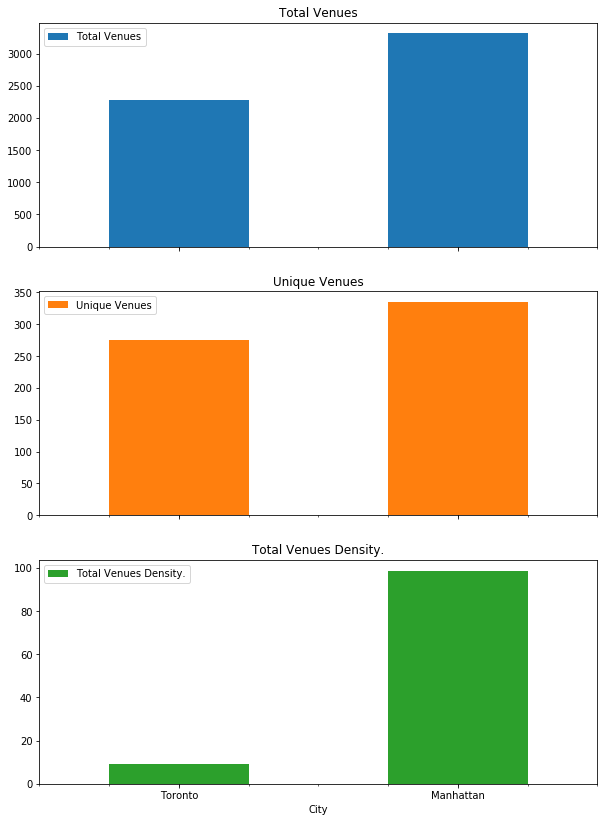

In [54]:
#compare.plot.barh()
axes = compare.plot.bar(rot=0,subplots=True,figsize=(10,14))
axes[1].legend(loc=2)  

In [60]:
man_coffee_shop = manhattan_venues[manhattan_venues['Venue Category'] == 'Coffee Shop']
mcs = man_coffee_shop.shape[0]
Tor_coffee_shop = toronto_venues[toronto_venues['Venue Category'] == 'Coffee Shop']
Tcs = Tor_coffee_shop.shape[0]
man_bar = manhattan_venues[manhattan_venues['Venue Category'] == 'Bar']
mbar = man_bar.shape[0]
Tor_bar = toronto_venues[toronto_venues['Venue Category'] == 'Bar']
Tbar = Tor_bar.shape[0]
man_steakhouse = manhattan_venues[manhattan_venues['Venue Category'] == 'Steakhouse']
m_steak = man_steakhouse.shape[0]
Tor_steakhouse = toronto_venues[toronto_venues['Venue Category'] == 'Steakhouse']
T_steak = Tor_steakhouse.shape[0]
man_park = manhattan_venues[manhattan_venues['Venue Category'] == 'Park']
mp = man_park.shape[0]
Tor_park = toronto_venues[toronto_venues['Venue Category'] == 'Park']
Tp = Tor_park.shape[0]

man_hotel = manhattan_venues[manhattan_venues['Venue Category'] == 'Hotel']
mhotel = man_hotel.shape[0]
Tor_hotel = toronto_venues[toronto_venues['Venue Category'] == 'Hotel']
Thotel = Tor_hotel.shape[0]

man_gym = manhattan_venues[manhattan_venues['Venue Category'] == 'Gym']
mgym = man_gym.shape[0]
Tor_gym = toronto_venues[toronto_venues['Venue Category'] == 'Gym']
Tgym = Tor_gym.shape[0]


man_golf = manhattan_venues[manhattan_venues['Venue Category'] == 'Golf Course']
mgolf = man_golf.shape[0]
Tor_golf = toronto_venues[toronto_venues['Venue Category'] == 'Golf Course']
Tgolf = Tor_golf.shape[0]

man_pool = manhattan_venues[manhattan_venues['Venue Category'] == 'Pool']
mpool = man_pool.shape[0]
Tor_pool = toronto_venues[toronto_venues['Venue Category'] == 'Pool']
Tpool = Tor_pool.shape[0]


In [61]:
# define the dataframe columns
column_names1 = ['City','Coffee Shops','Bars', 'Hotel', 'Steakhouse'] 
data1 = [['Toronto', int(Tcs),int(Tbar), int(Thotel),int(T_steak)], 
        ['Manhattan',int(mcs),int(mbar),int(mhotel),int(m_steak)]]

# instantiate the dataframe
compare1 = pd.DataFrame(data1,columns=column_names1).set_index('City')
compare1

Coffee Shops  Bars  Hotel  Steakhouse
City                                            
Toronto             189    44     43          22
Manhattan           118    51     71          26

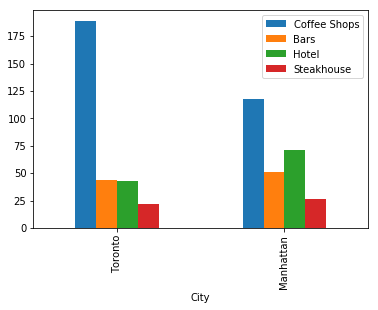

In [62]:
compare1.plot.bar()
#axes = compare1.plot.bar(rot=0,subplots=False,figsize=(8,12))
#axes[1].legend(loc=2) 

In [63]:
# define the dataframe columns
column_names2 = ['City','Gym','Park', 'Golf Course', 'Pool'] 
data2 = [['Toronto', int(Tgym),int(Tp),int(Tgolf), int(Tpool)], 
        ['Manhattan',int(mgym),int(mp),int(mgolf), int(mpool)]]

# instantiate the dataframe
compare2 = pd.DataFrame(data2,columns=column_names2).set_index('City')
compare2

Gym  Park  Golf Course  Pool
City                                   
Toronto     32    53            1     4
Manhattan   60    64            1     4

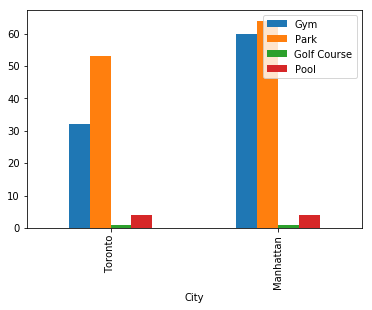

In [64]:
compare2.plot.bar()

### Conclusions and Outcome:

•	Both Manhattan and Toronto neighborhood have very diverse and dynamic environment which make both a very nice place to spend the weekend or in general a nice tourist place. 

•	Manhattan has 31% more total venues compared to Toronto. One notable aspect of it is Manhattan has an area of ~33 square miles while Toronto has an area of ~243 square miles. This tells us that Manhattan area has a much higher venue density, meaning, most of these venues are easily accessible if one can browse around on foot. In other words, the venues are comparatively closer in Manhattan area than the Toronto area. In addition, Manhattan has 18% more unique venues than Toronto which makes Manhattan more interesting or lucrative compared to Toronto.


•	One interesting observation is Manhattan has more Bars, Steakhouses and Hotels in the smaller area compared to the bigger Toronto area. But at the same time Toronto has ~40% more coffee shops than the Manhattan area. So, this can be a very good indication of what to expect in the respective area.

•	Another important outcome is Manhattan has more fitness centers and parks in a smaller area compared to Toronto. At the same time, both the neighborhoods have the same number of pools and Golf course


•	Although both neighborhoods have their own characteristics, I would put Manhattan at a slightly higher position as a lively tourists’ spot.  However, as a weekend gateway or couple of days of relaxing days out, I would put Toronto at a slightly higher position because with all the necessary venues in it, it is a bit less densely populated and it seems to be more peaceful than Manhattan.    
